In [1]:
from collections import defaultdict
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import patsy

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
cwd = pathlib.Path.cwd()
data_path = cwd / 'data'
pkl_path = data_path / 'pkl'
observations_pkl = pkl_path /'observations.pkl'

df = pd.read_pickle(observations_pkl).astype(float)
df['Percent_Passed'] = df['Percentage_Standard_Met_and_Above']
df['Math'] = df['Test_Id'] - 1
df['Mean_Score'] = df['Mean_Scale_Score']
df['Percent_Tested'] = df['Students_Tested'] / df['CAASPP_Reported_Enrollment']
df['Participation_95'] = (df['Percent_Tested'] > 0.95).astype(int)
df = df[['Median_Income', 'Percent_Passed', 'Math', 'Participation_95', 'Percent_Tested', 'Grade', 'Mean_Score']]

In [154]:
y, X = patsy.dmatrices('np.log(Median_Income) ~ Math * np.log(Grade) * Mean_Score * np.log(Percent_Passed + 1) + np.log(1.01-Percent_Tested) - Math:np.log(Grade):Mean_Score:np.log(Percent_Passed + 1) + 0'
                       , data=df)

linreg = LinearRegression()
fit = linreg.fit(X, y)
r_squared = linreg.score(X, y)
adjusted_r_squared = 1 - (1 - r_squared) * len(y) / (len(y) - X.shape[1] - 1)
rmse = np.sqrt(mean_squared_error(y, fit.predict(X)))


y_df = pd.DataFrame(y, columns=y.design_info.column_names)
X_df = pd.DataFrame(X, columns=X.design_info.column_names)
interactions = pd.concat([X_df, y_df], axis=1)

print('Intercept:', fit.intercept_)
print('R^2 Score:', r_squared)
print('Adj R^2 Score:', adjusted_r_squared)
print('RMSE Score:', rmse)

Intercept: [14.41902442]
R^2 Score: 0.3200935826200998
Adj R^2 Score: 0.319902436593285
RMSE Score: 0.31029534106984746


In [155]:
X.design_info.column_names

['Math',
 'np.log(Grade)',
 'Math:np.log(Grade)',
 'Mean_Score',
 'Math:Mean_Score',
 'np.log(Grade):Mean_Score',
 'Math:np.log(Grade):Mean_Score',
 'np.log(Percent_Passed + 1)',
 'Math:np.log(Percent_Passed + 1)',
 'np.log(Grade):np.log(Percent_Passed + 1)',
 'Math:np.log(Grade):np.log(Percent_Passed + 1)',
 'Mean_Score:np.log(Percent_Passed + 1)',
 'Math:Mean_Score:np.log(Percent_Passed + 1)',
 'np.log(Grade):Mean_Score:np.log(Percent_Passed + 1)',
 'np.log(1.01 - Percent_Tested)']

In [88]:
import statsmodels.api as sm

lm = sm.OLS(y, sm.add_constant(X))
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     1786.
Date:                Thu, 24 Jan 2019   Prob (F-statistic):               0.00
Time:                        13:58:43   Log-Likelihood:                -14158.
No. Observations:               56928   AIC:                         2.835e+04
Df Residuals:                   56912   BIC:                         2.849e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.4190      0.764     18.876      0.000      12.922      15.916
x1            -4.7468      0.657     -7.229      0.000      -6.034      -3.460
x2            -2.7991      0.419     -6.674      0.000      -3.621      -1.977
x3             1.4914      0.351      4.249      0.000       0.803       2.179
x4            -0.0015      0.000     -4.661      0.000      -0.002      -0.001
x5             0.0020      0.000      7.205      0.000       0.001       0.003
x6             0.0012      0.000      6.786      0.000       0.001       0.002
x7            -0.0006      0.000     -4.486      0.000      -0.001      -0.000
x8           -24.5302      1.445    -16.971      0.000     -27.363     -21.697
x9             2.6362      0.677      3.897      0.000       1.310       3.962
x10            5.7985      0.793      7.316      0.000       4.245       7.352
x11            0.3967      0.072      5.475      0.000       0.255       0.539
x12            0.0110      0.001     18.507      0.000       0.010       0.012
x13           -0.0014      0.000     -4.899      0.000      -0.002      -0.001
x14           -0.0029      0.000     -8.954      0.000      -0.004      -0.002
x15            0.0413      0.002     23.915      0.000       0.038       0.045
==============================================================================
Omnibus:                      617.795   Durbin-Watson:                   0.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              732.422
Skew:                          -0.196   Prob(JB):                    9.05e-160
Kurtosis:                       3.394   Cond. No.                     7.91e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.91e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

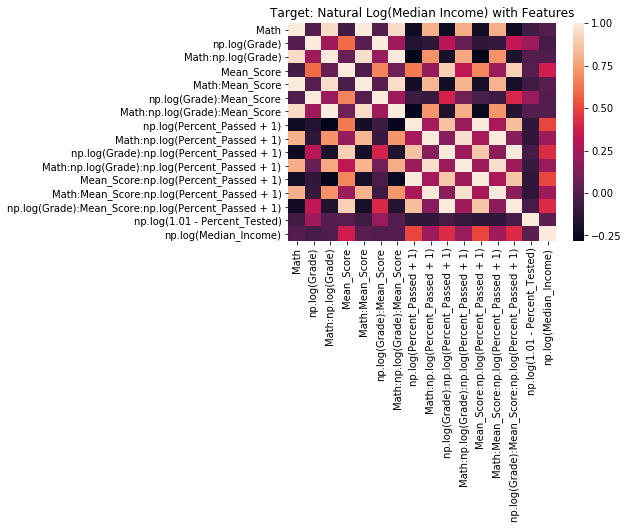

In [192]:
plot = sns.heatmap(interactions.corr())
plt.title('Target: Natural Log(Median Income) with Features')
plot.get_figure().savefig('heatmap.svg', bbox_inches='tight');

In [156]:
# sns.pairplot(interactions);

In [ ]:
# Percent error change happens with RMSE logged

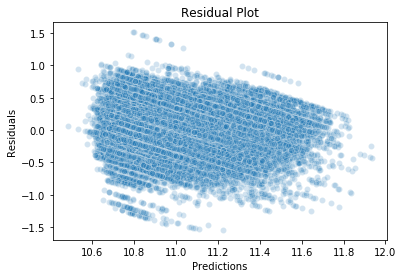

In [190]:
#: For sklearn fit

predictions = fit.predict(X)
residuals = y - fit.predict(X)
plot = sns.scatterplot(x=predictions.ravel(), y=residuals.ravel(), alpha=0.2)
plt.title('Residual Plot')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plot.get_figure().savefig('residuals.svg', bbox_inches='tight');

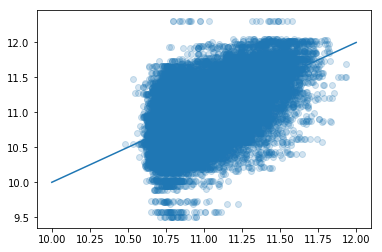

In [199]:
plt.scatter(predictions, y, alpha=0.2)
plt.plot([10, 12] , [10, 12]);

# Cross Fold Validation (80-20) (Train, Test)

In [118]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_, y_ = np.array(X_), np.array(y_)

lasso_adj_r2 = defaultdict(list)
ridge_adj_r2 = defaultdict(list)

lasso_mse = defaultdict(list)
ridge_mse = defaultdict(list)

kfold = KFold(n_splits=5, shuffle=True, random_state=10)

for alpha in np.arange(0.003, 1, 0.001):
    for train_idx, valid_idx in kfold.split(X_, y_):
        X_train, y_train = X_[train_idx], y_[train_idx]
        X_valid, y_valid = X_[valid_idx], y_[valid_idx]

        scaler = StandardScaler()
        X_train_scale = scaler.fit_transform(X_train)
        X_valid_scale = scaler.transform(X_valid)

        #: Ridge
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scale, y_train)
        
        r2 = ridge.score(X_valid_scale, y_valid)
        adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid_scale.shape[1] - 1)
        ridge_adj_r2[alpha].append(adj_r2)

        mse = mean_squared_error(y_valid, ridge.predict(X_valid_scale))
        ridge_mse[alpha].append(mse)
        
        #: LASSO
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train_scale, y_train)
        
        r2 = lasso.score(X_valid_scale, y_valid)
        adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid_scale.shape[1] - 1)
        lasso_adj_r2[alpha].append(adj_r2)
        
        mse = mean_squared_error(y_valid, lasso.predict(X_valid_scale))
        lasso_mse[alpha].append(mse)

In [137]:
lasso_mse_mean = {alpha: np.mean(mse) for alpha, mse in lasso_mse.items()}
lasso_mse_optimal = min(lasso_mse_mean.items(), key=lambda x: x[1])

lasso_adj_r2_mean = {alpha: np.mean(adj_r2) for alpha, adj_r2 in lasso_adj_r2.items()}
lasso_adj_r2_optimal = max(lasso_adj_r2_mean.items(), key=lambda x: x[1])

In [141]:
ridge_mse_mean = {alpha: np.mean(mse) for alpha, mse in ridge_mse.items()}
ridge_mse_optimal = min(ridge_mse_mean.items(), key=lambda x: x[1])

ridge_adj_r2_mean = {alpha: np.mean(adj_r2) for alpha, adj_r2 in ridge_adj_r2.items()}
ridge_adj_r2_optimal = max(ridge_adj_r2_mean.items(), key=lambda x: x[1])

In [130]:
linreg_adj_r2 = []
linreg_mse = []

for train_idx, valid_idx in kfold.split(X_, y_):
        X_train, y_train = X_[train_idx], y_[train_idx]
        X_valid, y_valid = X_[valid_idx], y_[valid_idx]

        linreg = LinearRegression()
        linreg.fit(X_train, y_train)
        
        r2 = linreg.score(X_valid, y_valid)
        adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid.shape[1] - 1)
        linreg_adj_r2.append(adj_r2)
        
        mse = mean_squared_error(y_valid, lm.predict(X_valid))
        linreg_mse.append(mse)

In [139]:
linreg_adj_r2_mean = np.mean(linreg_adj_r2)
linreg_mse_mean = np.mean(linreg_mse)

### Looks like OLS ties with Ridge so I'll use the more basic

In [145]:
linreg_mse_mean,    lasso_mse_optimal[1],    ridge_mse_optimal[1]

(0.0961480623823469, 0.09928007729463802, 0.09622461416257573)

In [146]:
linreg_adj_r2_mean, lasso_adj_r2_optimal[1], ridge_adj_r2_optimal[1]

(0.3178969783621216, 0.2962682216810674, 0.3178981756125495)

In [147]:
poly_adj_r2 = defaultdict(list)
poly_mse = defaultdict(list)

for degree in range(5):
    for train_idx, valid_idx in kfold.split(X_, y_):
        X_train, y_train = X_[train_idx], y_[train_idx]
        X_valid, y_valid = X_[valid_idx], y_[valid_idx]
        
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_valid_poly = poly.transform(X_valid)

        poly = LinearRegression()
        poly.fit(X_train_poly, y_train)
        r2 = poly.score(X_valid_poly, y_valid)
        adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid_poly.shape[1] - 1)
        poly_adj_r2[degree].append(adj_r2)
        
        mse = mean_squared_error(y_valid, poly.predict(X_valid_poly))
        poly_mse[degree].append(mse)

In [150]:
poly_mse_mean = {degree: np.mean(mse) for degree, mse in poly_mse.items()}
poly_adj_r2_mean = {degree: np.mean(adj_r2) for degree, adj_r2 in poly_adj_r2.items()}

### Polynomial doesn't have better performance than OLS

In [151]:
poly_mse_mean

{0: 0.14139573391162893,
 1: 0.09622474430238122,
 2: 0.09544601354565166,
 3: 0.09466582332377636,
 4: 0.09458669682408569}

In [152]:
poly_adj_r2_mean

{0: -0.0005043993899957577,
 1: 0.3178219511360753,
 2: 0.3142979761600732,
 3: 0.264108030748814,
 4: -0.1654121381982779}

### Now test OLS with the 80% train without CV

In [196]:
linreg = LinearRegression()
linreg.fit(X_, y_)

r2 = linreg.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, linreg.predict(X_test)))

r2, rmse, linreg.intercept_[0], linreg.coef_

(0.3201368690796251,
 0.31127794011508,
 14.593099762835292,
 array([[-4.81044935e+00, -2.87519772e+00,  1.54721400e+00,
         -1.56728728e-03,  2.05380992e-03,  1.19821852e-03,
         -6.68480050e-04, -2.51288296e+01,  2.67649433e+00,
          5.87270584e+00,  3.91968194e-01,  1.11896010e-02,
         -1.39442407e-03, -2.90324785e-03,  4.17529333e-02]]))

How I collected data
Why I chose topic
Understanding Results
Next Steps
Appendix

- What is the topic and why is this important
- Where/How you collected the data
- Tools use
- What were the benefits of the Feature Engineering vs just using a nieve model
- What other types of models did I try --> why did I choose OLS over Ridge despite it being slightly worse?
- 
dept of educ: https://pbs.twimg.com/profile_images/938093844146483200/FBIh5VvF.jpg  
money stack: http://www.onlineinvestingai.com/blog/wp-content/uploads/2009/12/passive-income.gif  
caaspp: http://p12cdn4static.sharpschool.com/UserFiles/Servers/Server_580721/Image/CAASPP/CAASPP%20TRANSPARENT.gif  
